# Flag alerts

Given a set of stops, add flags to indicate which have been canceled/modified in advance.


In [1]:
# imports 

import boto3
import os
import pandas as pd
import zipfile
import requests
import pendulum
from io import BytesIO
import shapely
import geopandas

In [2]:
# if "private", will assume you have write permissions and allow you to write; else will not attempt to write files
BUCKET_TYPE = "private"

In [3]:
# Pull in static data
trips_scheduled = pd.read_parquet(f's3://rtd-ghost-buses-{BUCKET_TYPE}/schedules/trips_scheduled.parquet')
stops_scheduled = pd.read_parquet(f's3://rtd-ghost-buses-{BUCKET_TYPE}/schedules/stops_scheduled.parquet')


In [11]:
trips_scheduled.head()

,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,trip_id,scheduled_service_date
0,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00
1,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-07-04 00:00:00-06:00
2,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-28 00:00:00-06:00
3,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-06-04 00:00:00-06:00
4,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-06-11 00:00:00-06:00


In [12]:
stops_scheduled.head()

,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,trip_id,service_date,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,arrival_datetime,departure_datetime
0,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00,08:22:00,08:22:00,24858,1,None,None,1,None,None,2023-05-29 08:22:00-06:00,2023-05-29 08:22:00-06:00
1,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00,08:22:45,08:22:45,25312,2,None,None,None,None,None,2023-05-29 08:22:45-06:00,2023-05-29 08:22:45-06:00
2,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00,08:23:40,08:23:40,17023,3,None,None,None,None,None,2023-05-29 08:23:40-06:00,2023-05-29 08:23:40-06:00
3,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00,08:24:24,08:24:24,17025,4,None,None,None,None,None,2023-05-29 08:24:24-06:00,2023-05-29 08:24:24-06:00
4,b_76 4,76,0,US36 & Bfld,1241914,SU_merged_114569133,114458891,2023-05-29 00:00:00-06:00,08:25:08,08:25:08,16946,5,None,None,None,None,None,2023-05-29 08:25:08-06:00,2023-05-29 08:25:08-06:00


In [8]:
# Pull in rt alerts data - whole folder
alerts_df = pd.read_parquet(f's3://rtd-ghost-buses-{BUCKET_TYPE}/processed/Alerts/')

In [9]:

alerts_df['alert.effect'].value_counts()
# NO_SERVICE            1334432
# DETOUR                 345271
# MODIFIED_SERVICE        76232
# UNKNOWN_EFFECT          72809
# OTHER_EFFECT            43167
# ADDITIONAL_SERVICE         44


NO_SERVICE            1334432
DETOUR                 345271
MODIFIED_SERVICE        76232
UNKNOWN_EFFECT          72809
OTHER_EFFECT            43167
ADDITIONAL_SERVICE         44
Name: alert.effect, dtype: int64

In [13]:
alerts_df.head()

,id,alert.activePeriod,alert.informedEntity,alert.cause,alert.effect,alert.headerText.translation,alert.descriptionText.translation,header.timestamp,filename
0,29112,"[{'end': '1672564020', 'start': '1672535580'}]","[{'agencyId': 'RTD', 'routeId': '103W', 'route...",OTHER_CAUSE,NO_SERVICE,"[{'language': 'en', 'text': 'W Line Trip 6:13 ...","[{'language': 'en', 'text': 'Affected trips: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
0,29106,"[{'end': '1672566420', 'start': '1672544520'}]","[{'agencyId': 'RTD', 'routeId': '43', 'routeTy...",OTHER_CAUSE,NO_SERVICE,"[{'language': 'en', 'text': 'Route 43 Trip 8:4...","[{'language': 'en', 'text': 'Affected trips: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
0,22731,"[{'end': '1680253140', 'start': '1657875600'}]","[{'agencyId': 'RTD', 'routeId': '21', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
0,29039,"[{'end': '1672567140', 'start': '1672480800'}]","[{'agencyId': 'RTD', 'routeId': '101D', 'route...",OTHER_CAUSE,MODIFIED_SERVICE,"[{'language': 'en', 'text': 'Planned schedule ...","[{'language': 'en', 'text': 'Following are fin...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
0,29120,"[{'end': '1672562040', 'start': '1672556220'}]","[{'agencyId': 'RTD', 'routeId': 'A', 'routeTyp...",POLICE_ACTIVITY,NO_SERVICE,"[{'language': 'en', 'text': 'A Line Trip 11:57...","[{'language': 'en', 'text': 'Affected directio...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...


In [21]:
print(len(alerts_df['id'].unique()))
# alerts_df.loc[alerts_df['id']=='29112'] #['alert.informedEntity']

4347


In [39]:
# Dedupe by id, order by header_timestamp ascending
alerts_deduped_df = alerts_df.sort_values(['id', 'header.timestamp']).groupby('id').first().reset_index()
alerts_deduped_df.head()

,id,alert.activePeriod,alert.informedEntity,alert.cause,alert.effect,alert.headerText.translation,alert.descriptionText.translation,header.timestamp,filename
0,11196,"[{'end': None, 'start': '1627290000'}]","[{'agencyId': 'RTD', 'routeId': '121', 'routeT...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
1,12906,"[{'end': None, 'start': '1634823920'}]","[{'agencyId': 'RTD', 'routeId': '52', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
2,13300,"[{'end': None, 'start': '1636624800'}]","[{'agencyId': 'RTD', 'routeId': '52', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
3,15312,"[{'end': None, 'start': '1641917760'}]","[{'agencyId': 'RTD', 'routeId': '15', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
4,15372,"[{'end': '1690880340', 'start': '1643104800'}]","[{'agencyId': 'RTD', 'routeId': '225', 'routeT...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...


In [59]:
print(alerts_deduped_df['alert.informedEntity'].apply(len))
print(alerts_deduped_df['alert.activePeriod'].apply(len).value_counts()) # There's one example with 6 activePeriod items in the list! Forget it, take first in list without guilt.
print(alerts_deduped_df['alert.headerText.translation'].apply(len).value_counts())
print(alerts_deduped_df['alert.descriptionText.translation'].apply(len).value_counts())


0        1
1        1
2        1
3        1
4        6
        ..
4342    12
4343     2
4344     1
4345     1
4346     6
Name: alert.informedEntity, Length: 4347, dtype: int64
1    4346
6       1
Name: alert.activePeriod, dtype: int64
1    4347
Name: alert.headerText.translation, dtype: int64
1    4347
Name: alert.descriptionText.translation, dtype: int64


In [58]:

# Case study
print(alerts_deduped_df.iloc[4342]) #['alert.informedEntity']

print(alerts_deduped_df.iloc[4342]['alert.informedEntity']) 
print(alerts_deduped_df.iloc[4342]['alert.headerText.translation'])
print(alerts_deduped_df.iloc[4342]['alert.descriptionText.translation'])#
# 4342

id                                                                               33507
alert.activePeriod                      [{'end': '1683010260', 'start': '1682975580'}]
alert.informedEntity                 [{'agencyId': 'RTD', 'routeId': '101D', 'route...
alert.cause                                                                OTHER_CAUSE
alert.effect                                                                NO_SERVICE
alert.headerText.translation         [{'language': 'en', 'text': 'D Line Trip 3:13 ...
alert.descriptionText.translation    [{'language': 'en', 'text': 'Affected trips:
...
header.timestamp                                                   2023-05-01 19:17:40
filename                             bus_data_Alerts/2023-05-01T13:18:11.880562-06:...
Name: 4342, dtype: object
[{'agencyId': 'RTD', 'routeId': '101D', 'routeType': 0, 'stopId': None, 'trip': {'tripId': '114368717'}}
 {'agencyId': 'RTD', 'routeId': '101D', 'routeType': 0, 'stopId': None, 'trip': {'tripI

(90,)
(71,)
False    4328
True       19
Name: alert_end, dtype: int64


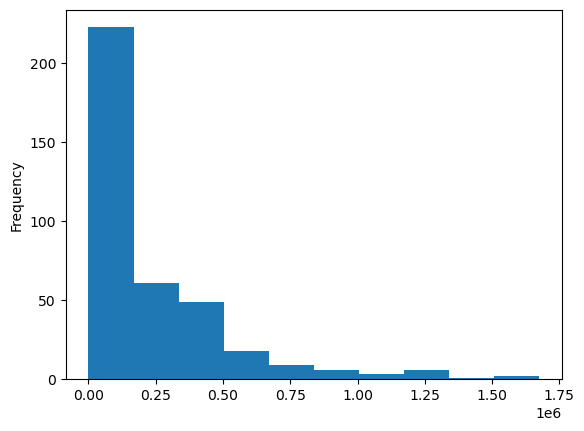

In [158]:
# Unwrap - get start and end
# TODO - prod code
alerts_deduped_df['alert_start'] = pd.to_datetime(alerts_deduped_df['alert.activePeriod'].apply(lambda x: x[0]['start']),unit='s', utc=True)
alerts_deduped_df['alert_end'] = pd.to_datetime(alerts_deduped_df['alert.activePeriod'].apply(lambda x: x[0]['end']),unit='s', utc=True)
# alerts_deduped_df['alert_end'] = pd.to_datetime(alerts_deduped_df['alert_end'])
# Advance notice of alert: Timedelta between header.timestamp in deduped (sorted) and alert_start
# alerts_deduped_df['header.timestamp'] = alerts_deduped_df['header.timestamp'].dt.tz_localize('America/Denver') # Only run once
alerts_deduped_df['advance_notice'] = alerts_deduped_df['alert_start'] - alerts_deduped_df['header.timestamp']
alerts_deduped_df['advance_notice'].sort_values() # Handful of negatives. Long-running before data collection? # Not Code
# alerts_deduped_df['advance_notice'].plot(kind='hist')
alerts_deduped_df.iloc[4344] # Not Code
alerts_deduped_df.loc[alerts_deduped_df['advance_notice'] >= pd.Timedelta(-1,'s'),'advance_notice'].dt.total_seconds().plot.hist() # # Not Code

# Fill in end date with max(header.timestamp) when end is empty & max(header.timestamp) for those rows is *not* the max across alerts_df (indicating that it's still ongoing)
no_end_list = alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()]['id'].tolist()
end_fill_df = alerts_df.loc[alerts_df['id'].isin(no_end_list)].groupby('id')['header.timestamp'].max()
print(end_fill_df.shape) # Not Code
end_fill_df = end_fill_df.loc[end_fill_df < alerts_df['header.timestamp'].max()]
end_fill_df.name = 'alert_end' # Rename to successfully use update later
print(end_fill_df.shape) # Not Code - 19 still ongoing as of May 1-ish
alerts_deduped_df2 = alerts_deduped_df.set_index('id')
alerts_deduped_df2.update(end_fill_df.dt.tz_localize('America/Denver'))

print(alerts_deduped_df2['alert_end'].isna().value_counts()) # Not Code

alerts_deduped_df = alerts_deduped_df2.reset_index()
# alerts_deduped_df2.index

In [230]:
# TODO Code to extract affected stops + trips
alerts_deduped_df.head()
# alerts_deduped_df['alert.informedEntity'].iloc[50][0] # For a given row, list of dicts with routeId:/stopId:/trip:{tripId:<string of trip id>)
alerts_deduped_df['affected_stops_list'] = alerts_deduped_df['alert.informedEntity'].apply(lambda x: [d['stopId'] for d in x]) # Stop Id's are all lists
alerts_deduped_df['affected_routes_list'] = alerts_deduped_df['alert.informedEntity'].apply(lambda x: [d['routeId'] for d in x])
alerts_deduped_df['affected_trips_list'] = alerts_deduped_df['alert.informedEntity'].apply(lambda x: [d['trip']['tripId'] for d in x if d['trip'] is not None] ) # Note, all ints
# alerts_deduped_df['alert.effect'].value_counts()
# ['NO_SERVICE', 'DETOUR', 'MODIFIED_SERVICE'] # Use these categories in alert.effect to flag reduced service 


In [252]:
alerts_deduped_df.head()

,id,alert.activePeriod,alert.informedEntity,alert.cause,alert.effect,alert.headerText.translation,alert.descriptionText.translation,header.timestamp,filename,alert_start,alert_end,advance_notice,affected_stops_list,affected_routes_list,affected_trips_list
0,11196,"[{'end': None, 'start': '1627290000'}]","[{'agencyId': 'RTD', 'routeId': '121', 'routeT...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55-07:00,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...,2021-07-26 09:00:00+00:00,NaT,-525 days +18:58:05,[15922],[121],[]
1,12906,"[{'end': None, 'start': '1634823920'}]","[{'agencyId': 'RTD', 'routeId': '52', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55-07:00,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...,2021-10-21 13:45:20+00:00,NaT,-438 days +23:43:25,[12319],[52],[]
2,13300,"[{'end': None, 'start': '1636624800'}]","[{'agencyId': 'RTD', 'routeId': '52', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55-07:00,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...,2021-11-11 10:00:00+00:00,NaT,-417 days +19:58:05,[12318],[52],[]
3,15312,"[{'end': None, 'start': '1641917760'}]","[{'agencyId': 'RTD', 'routeId': '15', 'routeTy...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55-07:00,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...,2022-01-11 16:16:00+00:00,NaT,-355 days +02:14:05,[35399],[15],[]
4,15372,"[{'end': '1690880340', 'start': '1643104800'}]","[{'agencyId': 'RTD', 'routeId': '225', 'routeT...",CONSTRUCTION,NO_SERVICE,"[{'language': 'en', 'text': 'The following sto...","[{'language': 'en', 'text': 'Affected routes: ...",2023-01-01 07:01:55-07:00,bus_data_Alerts/2023-01-01T00:03:11.963781-07:...,2022-01-25 10:00:00+00:00,2023-08-01 08:59:00+00:00,-342 days +19:58:05,"[12609, 12609, 12609, 12609, 12609, 12609]","[225, 225D, 225T, DASH, SKIP, 204]",[]


In [253]:
# TODO Code to apply these to the trips_scheduled / stops_scheduled datasets
# merge between stop and end
 #Can also try pandasql, but this supposedly has better performance

# Create dataframes with start time/stop time/affected (route/trip/stop)
# One dataframe per kind
# Drop duplicates to cover for cases where the alerts repeat the same info

alerts_deduped_df['affected_stops_list'].explode() # index is numeric index, not alert id.
alerts_cols = ['id','alert_start', 'alert_end','advance_notice','alert.cause', 'alert.effect']
affected_stops_df = alerts_deduped_df[alerts_cols].merge(alerts_deduped_df['affected_stops_list'].explode(), left_index = True, right_index = True)
affected_stops_df['affected_stops_list'] = affected_stops_df['affected_stops_list'].astype(str)
affected_stops_df = affected_stops_df.drop_duplicates()

affected_trips_df = alerts_deduped_df[alerts_cols].merge(alerts_deduped_df['affected_trips_list'].explode(), left_index = True, right_index = True)
affected_trips_df['affected_trips_list'] = affected_trips_df['affected_trips_list'].astype(str)
affected_stops_df = affected_stops_df.drop_duplicates()

affected_routes_df = alerts_deduped_df[alerts_cols].merge(alerts_deduped_df['affected_routes_list'].explode(), left_index = True, right_index = True)
affected_routes_df['affected_routes_list'] = affected_routes_df['affected_routes_list'].astype(str)
affected_routes_df = affected_routes_df.drop_duplicates()


In [254]:
# Add flag by first converting to something I can run a sql query on:
import duckdb

trips_scheduled_duck = duckdb.query(
    "SELECT * FROM trips_scheduled"
).to_df() # 1 second
stops_scheduled_duck = duckdb.query(
    "SELECT * FROM stops_scheduled limit 10000"
).to_df() # More seconds
affected_stops_duck = duckdb.query("SELECT * FROM affected_stops_df").to_df()
affected_trips_duck = duckdb.query("SELECT * FROM affected_trips_df").to_df()
affected_routes_duck = duckdb.query("SELECT * FROM affected_routes_df").to_df()



In [255]:
affected_stops_duck.drop_duplicates()
affected_stops_duck

,id,alert_start,alert_end,advance_notice,alert.cause,alert.effect,affected_stops_list
0,11196,2021-07-26 09:00:00+00:00,NaT,-525 days +18:58:05,CONSTRUCTION,NO_SERVICE,15922
1,12906,2021-10-21 13:45:20+00:00,NaT,-438 days +23:43:25,CONSTRUCTION,NO_SERVICE,12319
2,13300,2021-11-11 10:00:00+00:00,NaT,-417 days +19:58:05,CONSTRUCTION,NO_SERVICE,12318
3,15312,2022-01-11 16:16:00+00:00,NaT,-355 days +02:14:05,CONSTRUCTION,NO_SERVICE,35399
4,15372,2022-01-25 10:00:00+00:00,2023-08-01 08:59:00+00:00,-342 days +19:58:05,CONSTRUCTION,NO_SERVICE,12609
...,...,...,...,...,...,...,...
14609,9636,2021-04-14 17:57:00+00:00,2023-01-01 10:00:00+00:00,-627 days +03:55:05,CONSTRUCTION,NO_SERVICE,14944
14610,9636,2021-04-14 17:57:00+00:00,2023-01-01 10:00:00+00:00,-627 days +03:55:05,CONSTRUCTION,NO_SERVICE,14942
14611,9636,2021-04-14 17:57:00+00:00,2023-01-01 10:00:00+00:00,-627 days +03:55:05,CONSTRUCTION,NO_SERVICE,35229
14612,9636,2021-04-14 17:57:00+00:00,2023-01-01 10:00:00+00:00,-627 days +03:55:05,CONSTRUCTION,NO_SERVICE,35230


In [256]:
alerts_deduped_df.dtypes
# affected_stops_df.dtypes
# affected_stops_duck

id                                                           object
alert.activePeriod                                           object
alert.informedEntity                                         object
alert.cause                                                  object
alert.effect                                                 object
alert.headerText.translation                                 object
alert.descriptionText.translation                            object
header.timestamp                     datetime64[ns, America/Denver]
filename                                                     object
alert_start                                     datetime64[ns, UTC]
alert_end                                       datetime64[ns, UTC]
advance_notice                                      timedelta64[ns]
affected_stops_list                                          object
affected_routes_list                                         object
affected_trips_list                             

In [257]:
# trips_scheduled_duck

merged_stops_duck = stops_scheduled_duck.merge(affected_stops_duck, 
                                                how = 'left',
                           left_on = 'stop_id',
                           right_on = 'affected_stops_list')
merged_stops_duck = merged_stops_duck[(merged_stops_duck['alert_start'] < merged_stops_duck['departure_datetime']) & 
                  (merged_stops_duck['alert_end'] > merged_stops_duck['departure_datetime'])]
# What to do? Prep to left join (merge) back into stops_scheduled_duck by stop dataframe index, keeping alert_start/alert_end/advance_notice/alert.cause/alert.effect   

In [258]:
merged_stops_duck


,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,trip_id,service_date,arrival_time,departure_time,...,timepoint,arrival_datetime,departure_datetime,id,alert_start,alert_end,advance_notice,alert.cause,alert.effect,affected_stops_list
8557,a_42 2,42,1,Central Park Stn via Montbello,1231610,WK_merged_114569125,114359580,2023-03-07 07:00:00+00:00,08:12:23,08:12:23,...,NaN,2023-03-07 15:12:23+00:00,2023-03-07 15:12:23+00:00,31425,2023-03-06 17:00:00+00:00,2023-03-10 22:30:00+00:00,2 days 13:52:51,CONSTRUCTION,NO_SERVICE,18804
13097,a_42 2,42,1,Central Park Stn via Montbello,1231610,WK_merged_114569125,114359580,2023-03-08 07:00:00+00:00,08:12:23,08:12:23,...,NaN,2023-03-08 15:12:23+00:00,2023-03-08 15:12:23+00:00,31425,2023-03-06 17:00:00+00:00,2023-03-10 22:30:00+00:00,2 days 13:52:51,CONSTRUCTION,NO_SERVICE,18804
14050,a_42 2,42,1,Central Park Stn via Montbello,1231610,WK_merged_114569125,114359580,2023-04-05 06:00:00+00:00,08:23:08,08:23:08,...,NaN,2023-04-05 14:23:08+00:00,2023-04-05 14:23:08+00:00,32521,2023-04-04 14:30:00+00:00,2023-04-07 21:30:00+00:00,0 days 11:58:51,CONSTRUCTION,NO_SERVICE,34858
17637,a_42 2,42,1,Central Park Stn via Montbello,1231610,WK_merged_114569125,114359580,2023-03-09 07:00:00+00:00,08:12:23,08:12:23,...,NaN,2023-03-09 15:12:23+00:00,2023-03-09 15:12:23+00:00,31425,2023-03-06 17:00:00+00:00,2023-03-10 22:30:00+00:00,2 days 13:52:51,CONSTRUCTION,NO_SERVICE,18804
18590,a_42 2,42,1,Central Park Stn via Montbello,1231610,WK_merged_114569125,114359580,2023-04-06 06:00:00+00:00,08:23:08,08:23:08,...,NaN,2023-04-06 14:23:08+00:00,2023-04-06 14:23:08+00:00,32521,2023-04-04 14:30:00+00:00,2023-04-07 21:30:00+00:00,0 days 11:58:51,CONSTRUCTION,NO_SERVICE,34858
22177,a_42 2,42,1,Central Park Stn via Montbello,1231610,WK_merged_114569125,114359580,2023-03-10 07:00:00+00:00,08:12:23,08:12:23,...,NaN,2023-03-10 15:12:23+00:00,2023-03-10 15:12:23+00:00,31425,2023-03-06 17:00:00+00:00,2023-03-10 22:30:00+00:00,2 days 13:52:51,CONSTRUCTION,NO_SERVICE,18804
23130,a_42 2,42,1,Central Park Stn via Montbello,1231610,WK_merged_114569125,114359580,2023-04-07 06:00:00+00:00,08:23:08,08:23:08,...,NaN,2023-04-07 14:23:08+00:00,2023-04-07 14:23:08+00:00,32521,2023-04-04 14:30:00+00:00,2023-04-07 21:30:00+00:00,0 days 11:58:51,CONSTRUCTION,NO_SERVICE,34858
31257,a_42 4,42,1,Central Park Stn via Montbello,1231610,WK_merged_114569125,114359583,2023-03-07 07:00:00+00:00,06:42:23,06:42:23,...,NaN,2023-03-07 13:42:23+00:00,2023-03-07 13:42:23+00:00,31425,2023-03-06 17:00:00+00:00,2023-03-10 22:30:00+00:00,2 days 13:52:51,CONSTRUCTION,NO_SERVICE,18804
35797,a_42 4,42,1,Central Park Stn via Montbello,1231610,WK_merged_114569125,114359583,2023-03-08 07:00:00+00:00,06:42:23,06:42:23,...,NaN,2023-03-08 13:42:23+00:00,2023-03-08 13:42:23+00:00,31425,2023-03-06 17:00:00+00:00,2023-03-10 22:30:00+00:00,2 days 13:52:51,CONSTRUCTION,NO_SERVICE,18804


## Sanity-checks


In [68]:
# Sanity-check
print(alerts_deduped_df['alert_start'].isna().value_counts())
print(alerts_deduped_df['alert_end'].isna().value_counts())
# 90 out of 4347 are missing an end. Is that a problem?
# Potentially, yes. Look for when the alert does *not* show up anymore?

False    4347
Name: alert_start, dtype: int64
False    4257
True       90
Name: alert_end, dtype: int64


In [186]:
alerts_deduped_df['alert_start'].sort_values()
print(alerts_deduped_df.iloc[4345])
print(alerts_deduped_df.iloc[4345]['alert.informedEntity'])
print(alerts_deduped_df.iloc[4345]['alert.headerText.translation'])
print(alerts_deduped_df.iloc[4345]['alert.descriptionText.translation'])


id                                                                                9635
alert.activePeriod                              [{'end': None, 'start': '1618420740'}]
alert.informedEntity                 [{'agencyId': 'RTD', 'routeId': '6', 'routeTyp...
alert.cause                                                                OTHER_CAUSE
alert.effect                                                                NO_SERVICE
alert.headerText.translation         [{'language': 'en', 'text': 'The following sto...
...rt.descriptionText.translation    [{'language': 'en', 'text': 'Affected routes:
header.timestamp                                             2023-01-01 07:01:55-07:00
filename                             bus_data_Alerts/2023-01-01T00:03:11.963781-07:...
alert_start                                                  2021-04-14 17:19:00+00:00
alert_end                                                                          NaT
advance_notice                                 

In [73]:
alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[0]
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[0]['alert.informedEntity'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[0]['alert.headerText.translation'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[0]['alert.descriptionText.translation'])

[{'agencyId': 'RTD', 'routeId': '121', 'routeType': 3, 'stopId': '15922', 'trip': None}]
[{'language': 'en', 'text': 'The following stop is closed beginning Mon Jul 26 due to construction: Peoria St & Colfax Ave (#15922) (southbound).'}]
[{'language': 'en', 'text': 'Affected routes:\r\n121\r\nBoard at the temporary stop located north of Colfax near the Grease Monkey'}]


In [74]:
alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[1]
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[1]['alert.informedEntity'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[1]['alert.headerText.translation'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[1]['alert.descriptionText.translation'])

[{'agencyId': 'RTD', 'routeId': '52', 'routeType': 3, 'stopId': '12319', 'trip': None}]
[{'language': 'en', 'text': 'The following stop is closed due to construction: Bannock St & W 11th Ave (#12319) (eastbound).\n'}]
[{'language': 'en', 'text': 'Affected routes:\r\n52'}]


In [75]:
alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[2]
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[2]['alert.informedEntity'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[2]['alert.headerText.translation'])
print(alerts_deduped_df.loc[alerts_deduped_df['alert_end'].isna()].iloc[2]['alert.descriptionText.translation'])

[{'agencyId': 'RTD', 'routeId': '52', 'routeType': 3, 'stopId': '12318', 'trip': None}]
[{'language': 'en', 'text': 'The following stop is closed beginning Thu Nov 11 due to construction: Bannock St & W 11th Ave (#12318) (westbound).'}]
[{'language': 'en', 'text': 'Affected routes:\r\n52\r\nBoard at temporary stop located at 12th Ave'}]
